<h2>
<center>Unsupervised learning for pairs selection</center>
</h2>
<h3>
<center>Applying PCA and OPTICS clustering to pair price selection</center>
</h3>


## Introduction
Pairs trading is a strategy used by many financial institutions. Within this strategy, fund managers attempt to construct a mean-reverting prices series of pairs of securities. As the prices series reverts to its long-term mean, the fund manager closes or opens positions accordingly to profit. As more financial securities are traded, the universe of potential pairs continues to balloon in size. This increase in size leads to more instances of spurious correlations among financial securities. To constrain the search universe and avoid spurious correlations, Sarmento and Horta outline an unsupervised clustering approach to find securities for pairs trading in their work: <a href="https://www.springer.com/gp/book/9783030472504#aboutBook"> “A Machine Learning based Pairs Trading Investment Strategy.”</a> [1].

Following the work of Sarmento and Horta, this notebook is dividend into three states: dimensionality reduction via principal component analysis, unsupervised clustering via OPTICS, and pairs selection via author proposed criteria. Finally, it concludes with an application of optimal entry and liquidation levels of portfolios composed of selected pairs and closing remarks.

## Body

### 0: Data collection

18 coins are selected for the purpose of this notebook, but it's worth noting that the model can easily support many more as was its intention. The price data is stored on a HDF5 file that can be accesed in the data folder.

**Inputs**

| - **to_time**:   | Starting time    | - Earliest date from 10/12/2021                                    |
|------------------|------------------|--------------------------------------------------------------------|
| - **from_time**: | End time         | - Latest date to 31/01/2022                                        |
| - **tf**:        | time frame       | - One of ["1m", "5m", "15m", "30m", "1h", "4h", "6h", "12h", "1d"] |
| - **Exchange**:  | Exchange to use  | - Currently only supporting Bitmex and Binance                     |

In [1]:
from mlpairs import OpticsPairs
import pandas as pd
import datetime
from database import Hdf5Client
from utils import resample_timeframe
from dateutil.relativedelta import relativedelta


# set variables
symbol_list = ["XBTUSD", "ETHUSD", "XRPUSD", "LTCUSD", "SOLUSD", "DOGEUSD", "ADAUSD", "BCHUSD", "LINKUSD", "BNBUSD", "LUNAUSD", "AVAXUSD", "DOTUSD", "AXSUSD", "EOSUSD", "ETHH22", "XRPH22", "ADAH22"]

from_time = '20/01/2022'
to_time = '25/01/2022'
tf = '1m'
exchange = "bitmex"
stock_prices = pd.DataFrame()


# Format time
try:
    from_time = int(datetime.datetime.strptime(
        from_time, "%d/%m/%Y").timestamp() * 1000)

    to_time = int(datetime.datetime.strptime(
        to_time, "%d/%m/%Y").timestamp() * 1000)

except ValueError as e:
    print("ERROR => ", e)

# Collect price data
for symbol in symbol_list:

    h5_db = Hdf5Client(exchange)
    data = h5_db.get_data(
        symbol, from_time=from_time, to_time=to_time)
    data = resample_timeframe(data, tf)

    stock_prices[symbol] = data["close"]
    stock_prices = stock_prices.fillna(method='ffill')

# Split testing and training data
train_to_test = '2022-01-23 00:00:00'

train = stock_prices[:train_to_test]
test = stock_prices[train_to_test:]

train.tail()

### State 1: Dimensionality Reduction  
### Calculate return series

In [2]:
op = OpticsPairs(train)
op.returns.head()

,XBTUSD,ETHUSD,XRPUSD,LTCUSD,SOLUSD,DOGEUSD,ADAUSD,BCHUSD,LINKUSD,BNBUSD,LUNAUSD,AVAXUSD,DOTUSD,AXSUSD,EOSUSD,ETHH22,XRPH22,ADAH22
timestamp,,,,,,,,,,,,,,,,,,
2022-01-20 00:01:00,-0.001043,-0.001390,0.000000,0.001537,0.000000,-0.001972,-0.007171,-0.002026,0.000000,0.0,-0.000922,0.000254,0.000829,-0.000978,0.000000,0.0,0.0,0.0
2022-01-20 00:02:00,0.001224,0.002590,-0.002567,-0.001462,0.000074,0.000926,-0.003160,-0.000135,-0.001019,0.0,0.000000,0.000000,0.000000,0.000000,-0.007085,0.0,0.0,0.0
2022-01-20 00:03:00,-0.000084,-0.000291,-0.000135,-0.001537,0.000221,0.000925,0.000830,0.000677,-0.002273,0.0,0.000000,-0.003670,0.000000,0.000000,-0.000951,0.0,0.0,0.0
2022-01-20 00:04:00,-0.000803,-0.002084,0.001219,0.001100,0.000000,0.000000,-0.004374,-0.000541,0.001209,0.0,0.000000,-0.000473,-0.002030,0.000000,0.000000,0.0,0.0,0.0
2022-01-20 00:05:00,-0.000756,0.000129,-0.000812,-0.001391,-0.002726,-0.001171,0.003030,0.000000,-0.001207,0.0,0.000000,-0.001091,-0.002242,-0.002657,0.000000,0.0,0.0,0.0


### Apply PCA

Principal component analysis is applied to the scaled return series. The below graphs plot the loadings on of each coins on the first five principal components.

### Step 1: Standardize Data

$$ z = \frac{x - \mu}{\sigma} $$

### Step 2: Compute Covariance Matrix

$$ cov(X, Y) = \frac{1}{N-1}\displaystyle\sum_{i=1}^{N}(X_i-\bar{x})(Y_i-\bar{y}) $$

### Step 3: Compute Eigenvectors and Eigenvalues


$$A\overrightarrow{v} = \lambda\overrightarrow{v}$$
$$ \overrightarrow{v}(A - \lambda I) = 0$$
Where $A$ is the covariance matrix, $I$ is the identity matrix, $\overrightarrow{v}$ are eigenvectors, and $\lambda$ are eigenvalues.

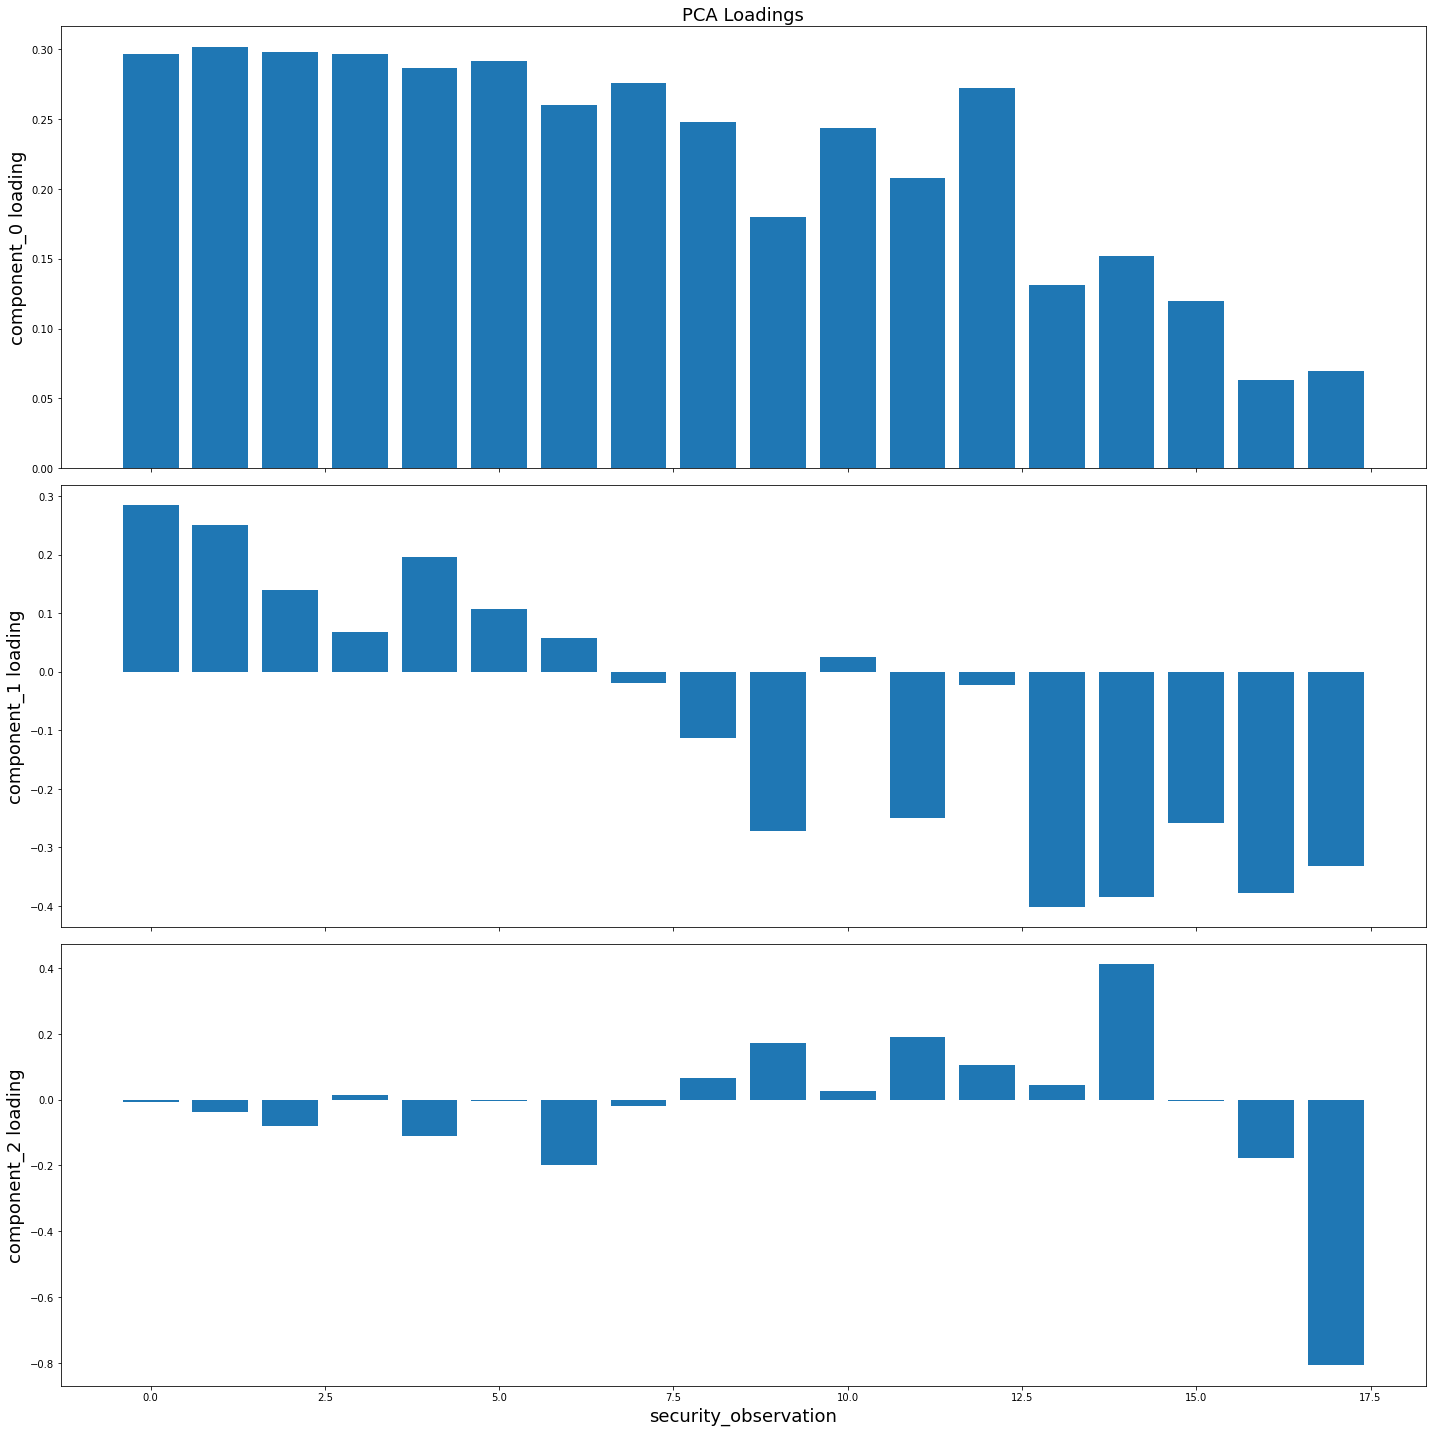

In [3]:
op.reduce_PCA()
op.plot_loadings()

Implementing PCA reduced the dimensions of our data from 2264x600 to 10x600. Below we chart the cumulative variance explained by the 10 dimensions in component space. We see the “market” component explains roughly 20% of the variance in price movements.


Total variance explained: 55.00000000000001%


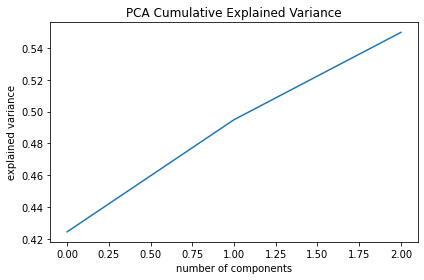

In [4]:
import numpy as np 
op.plot_explained_variance()
total_variance_explained = np.cumsum(op.explained_variance_ratio_)[-1]
print(f"Total variance explained: {round(total_variance_explained, 2)*100}%")

## State 2: Unsupervised Learning
### Apply OPTICS


Unlike other clustering algorithms, OPTICS computes an augmented cluster-ordering of the data rather than clustering the data explicitly. This frees the algorithm from relying on global parameters that might be heavily influenced by one cluster, but not accurately describe other clusters. Ankerst et. al state, “It is a versatile basis for both automatic and interactive
cluster analysis” [2]. 

A point $p$ is considered a core point if at least $MinPts$ are found within its $\epsilon$-neighborhood. Each point is given a core-dist which denotes the distance to the nearest $MinPts$th closest point. The calculation for core-dist is described below:

$${\displaystyle {\text{core-dist}}_{\mathit {\varepsilon ,MinPts}}(p)={\begin{cases}{\text{UNDEFINED}}&{\text{if }}|N_{\varepsilon }(p)|<{\mathit {MinPts}}\\{\mathit {MinPts}}{\text{-th smallest distance in }}N_{\varepsilon }(p)&{\text{otherwise}}\end{cases}}}$$

The reachability-distance of another point $o$ from a point $p$ is either the distance between $o$ and $p$, or the core distance of $p$, whichever is bigger. The calculation for core-dist is described below:

$${\displaystyle {\text{reachability-dist}}_{\mathit {\varepsilon ,MinPts}}(o,p)={\begin{cases}{\text{UNDEFINED}}&{\text{if }}|N_{\varepsilon }(p)|<{\mathit {MinPts}}\\\max({\text{core-dist}}_{\mathit {\varepsilon ,MinPts}}(p),{\text{dist}}(p,o))&{\text{otherwise}}\end{cases}}}$$

If $p$ and $o$ are nearest neighbors, this is the ${\displaystyle \varepsilon '<\varepsilon }$ we need to assume to have $p$ and $o$ belong to the same cluster.

### Generate clusters and find potential trading pairs

The OPTICS algorithm identified 323 potential pairs of securities that share a common label generated from unsupervised learning.


In [5]:
op.find_pairs()
op.pairs

Found 153 potential pairs


0       (XBTUSD, ETHUSD)
1       (XBTUSD, XRPUSD)
2       (XBTUSD, LTCUSD)
3       (XBTUSD, SOLUSD)
4      (XBTUSD, DOGEUSD)
             ...        
148     (EOSUSD, XRPH22)
149     (EOSUSD, ADAH22)
150     (ETHH22, XRPH22)
151     (ETHH22, ADAH22)
152     (XRPH22, ADAH22)
Length: 153, dtype: object

To visually inspect the clusters, we plot the loadings of the first two and first three principal components from each security. We can clearly see one cluster of securities that stands out from the rest in the upper left of the 2-dimensional graph. Additionally, when adding a third principal component, we can more easily see other clusters group together along the z-axis.

The light points share a common label indicate data points considered noise and are excluded and the corresponding securities are excluded from the potential pairs list. 


### Plot clusters found

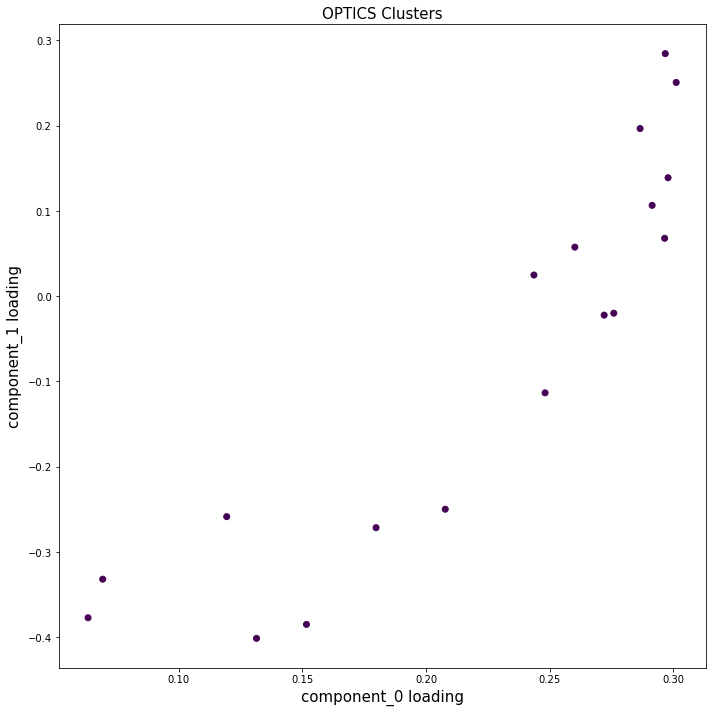

In [6]:
op.plot_clusters(n_dimensions=2)


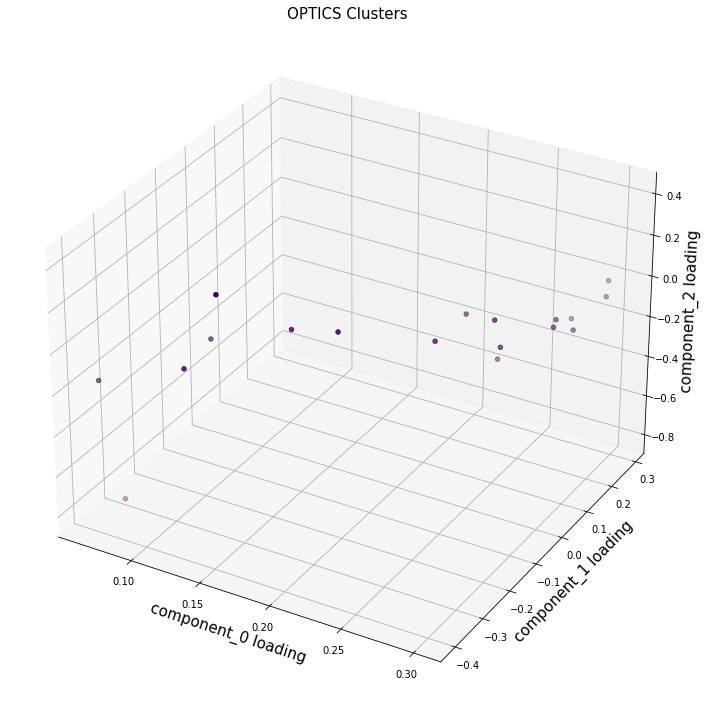

In [7]:
op.plot_clusters(n_dimensions=3)

## State 3: Select Pairs
### Apply Critera

Sarmento and Horta suggest four criteria to further filter the potential pairs to increase the probability of selecting pairs of securities whose prices will continue to mean revert in the future. 
* Statistically significant t-stat from the Engle-Granger test (5% level)
* Hurst exponent < 0.5  
* Half-life between [1, 252]   
* Spread must cross the mean on average 12x per year  

These four criteria indicate positive characteristics for potential pairs of securities. The Engle-Granger tests the pair for cointegration. A Hurst exponent below 0.5 indicates that the pair of prices regresses strongly to the mean. Pairs with extreme half-life values, below 1 or above 252, are excluded from the selected pairs. Extreme half-life values indicate a price series that either reverts too quickly or too slowly to be traded. Finally, the price series must cross the long-term spread mean on average 12 times a year. This enforces one trade on average, per month.

After filtering potential pairs, we find 7 pairs of securities that meet all four criteria. We plot the prices individual prices series and the beta-adjusted spread for each pair below.


### Engle-Granger Test

If $x_t$ and $y_t$ are non-stationary and order of integration d=1, then a linear combination of them must be stationary for some value of $\beta$ and $\mu_t$.   
<br>
<center> $y_t - \beta x_t = \mu_t$ ; where $\mu_t$ is stationary. </center>

### Hurst Exponent Calculation
The Hurst exponent, H, is used to measure the long-term memory of a time series. A value in the range of [0-0.5) indicates that a time series reverts strongly to the mean while a value of [0.5-1] indicates a time series with long-term positive autocorrelation and is likely to diverge. The Hurst exponent is calculated as: 

<br>
<center> $\begin{aligned} \mathbb{E}\big[\frac{R(n)}{S(n)}\big] = Cn^H , n \rightarrow \infty\end{aligned}$</center>
$R(n)$ is the range of the first $n$ cumulative deviations from the mean.  
$S(n)$ is the series of the first $n$ standard deviations.  
$\mathbb{E}$ is the expected value.  
$n$ is the number of observations in the time series.  
$C$ is a constant.  

### Half-life Calculation

The half-life of a series is the amount of time it takes for a series to return to half its initial value and is defined as: 

<br>
<center> $\begin{aligned} N(t) = N_0e^{-\lambda t} \end{aligned}$</center>
$N_0$ is the initial quantity of the spread that will decay.  
$N(t)$ is the quantity that still remains and has not yet decayed after a time $t$.  
$\lambda$ is a positive number called the decay constant.  

The half-life, $t_{1/2}$ is defined as:
<center> $\begin{aligned} t_{1/2} = \frac{ln(2)}{\lambda} \end{aligned}$</center>


Spreads with short half-lives indicate portfolios that revert to the mean often and create many trading opportunities.

### Calculate potential pair statistics

In [8]:
op.calc_eg_norm_spreads()
op.calc_hurst_exponents()
op.calc_half_lives()
op.calc_avg_cross_count()

### Filter potential pairs

In [9]:
op.filter_pairs()
op.filtered_pairs

Found 12 tradable pairs!


,pair,pvalue,hurst_exp,half_life,avg_cross_count
29,"(ETHUSD, EOSUSD)",0.046628,0.219891,28.707934,13.471882
44,"(XRPUSD, EOSUSD)",0.011577,0.208126,18.350415,17.787549
50,"(LTCUSD, ADAUSD)",0.000246,0.370721,28.060200,19.653784
70,"(SOLUSD, AXSUSD)",0.003780,0.250777,22.418877,12.830363
71,"(SOLUSD, EOSUSD)",0.025458,0.234045,23.767384,16.679472
83,"(DOGEUSD, EOSUSD)",0.005994,0.211616,19.379793,17.204351
88,"(ADAUSD, LINKUSD)",0.011115,0.351764,37.302661,12.247165
101,"(BCHUSD, AVAXUSD)",0.006265,0.285520,19.544173,18.254108
102,"(BCHUSD, DOTUSD)",0.019670,0.421546,37.229019,12.772044
104,"(BCHUSD, EOSUSD)",0.000210,0.199040,13.058886,15.279796


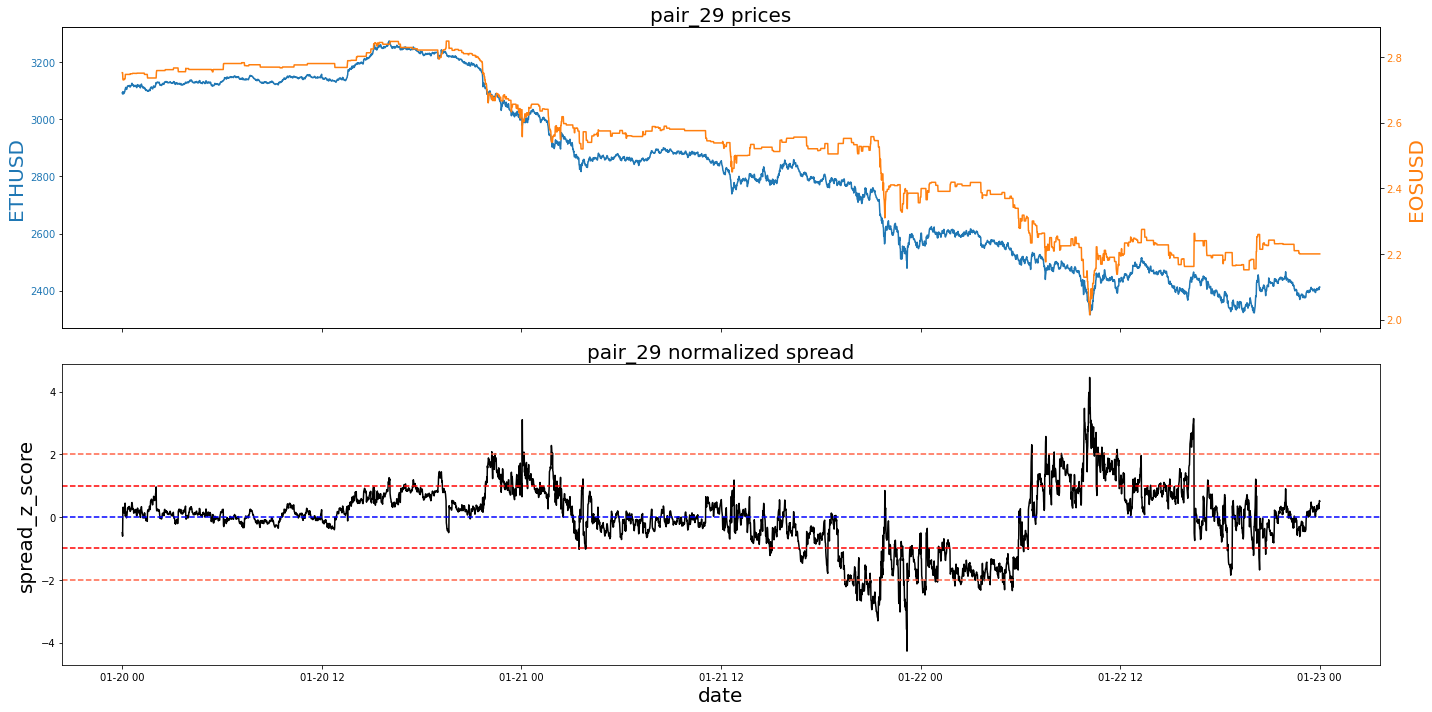

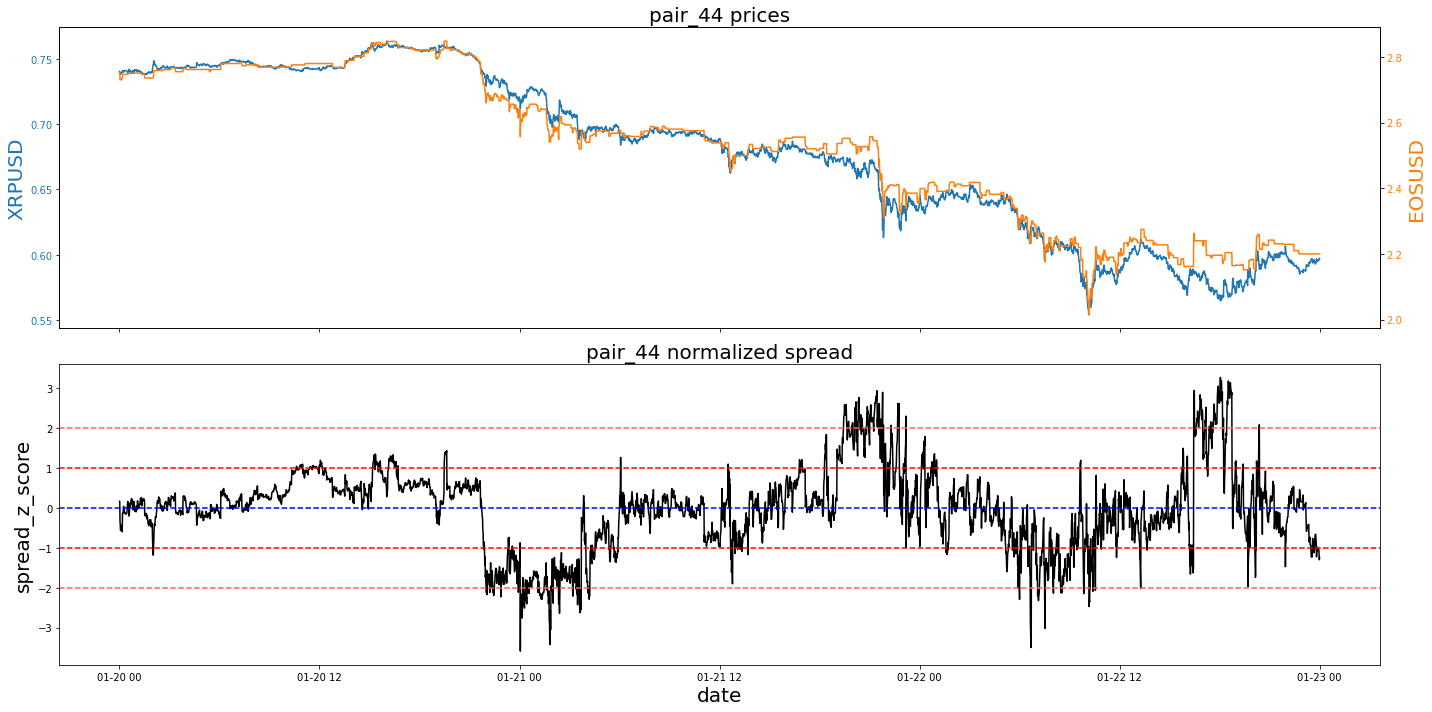

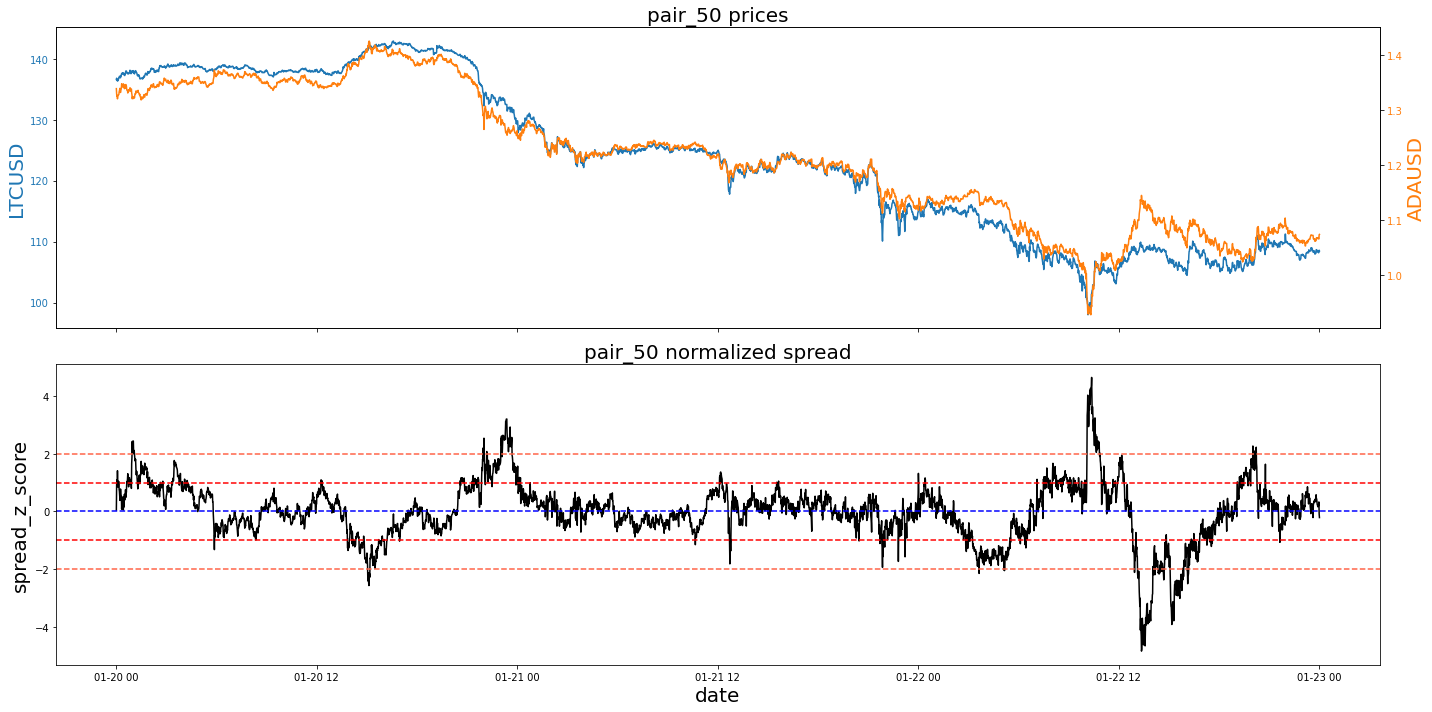

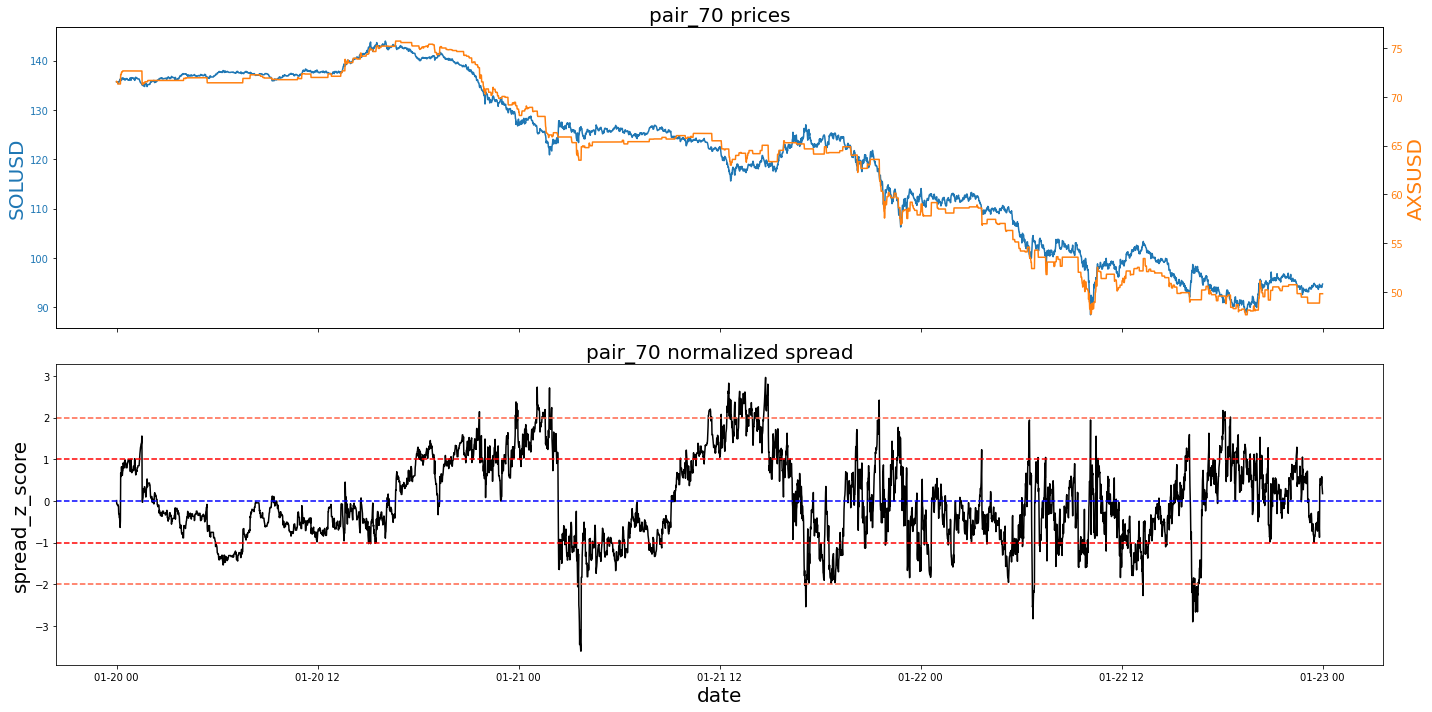

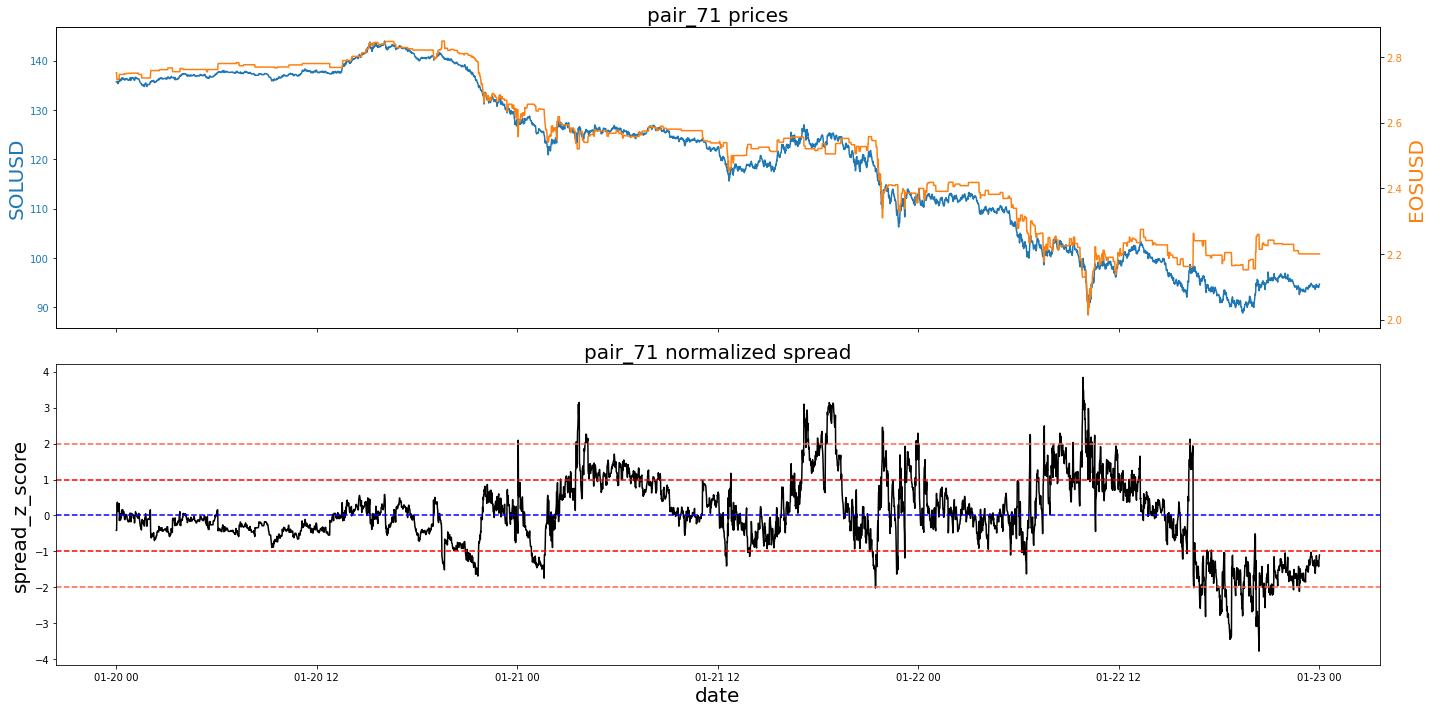

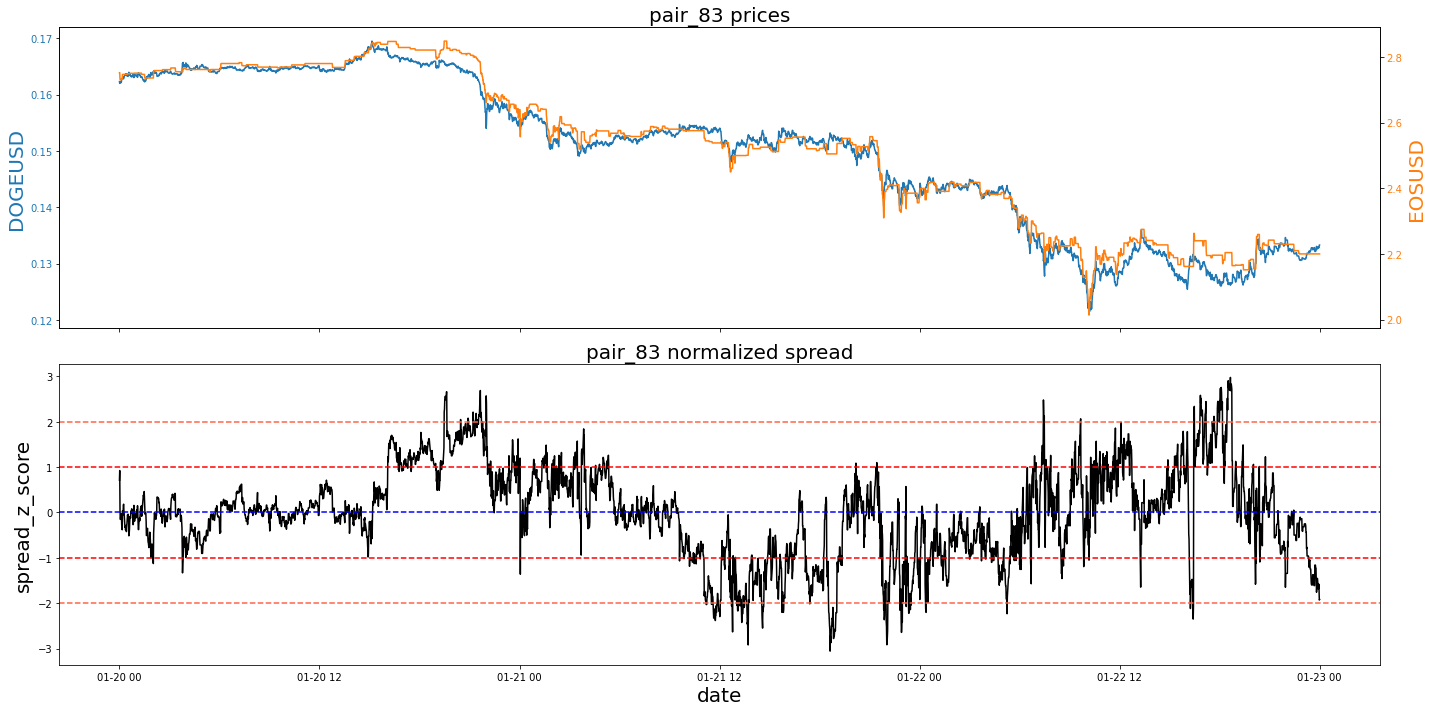

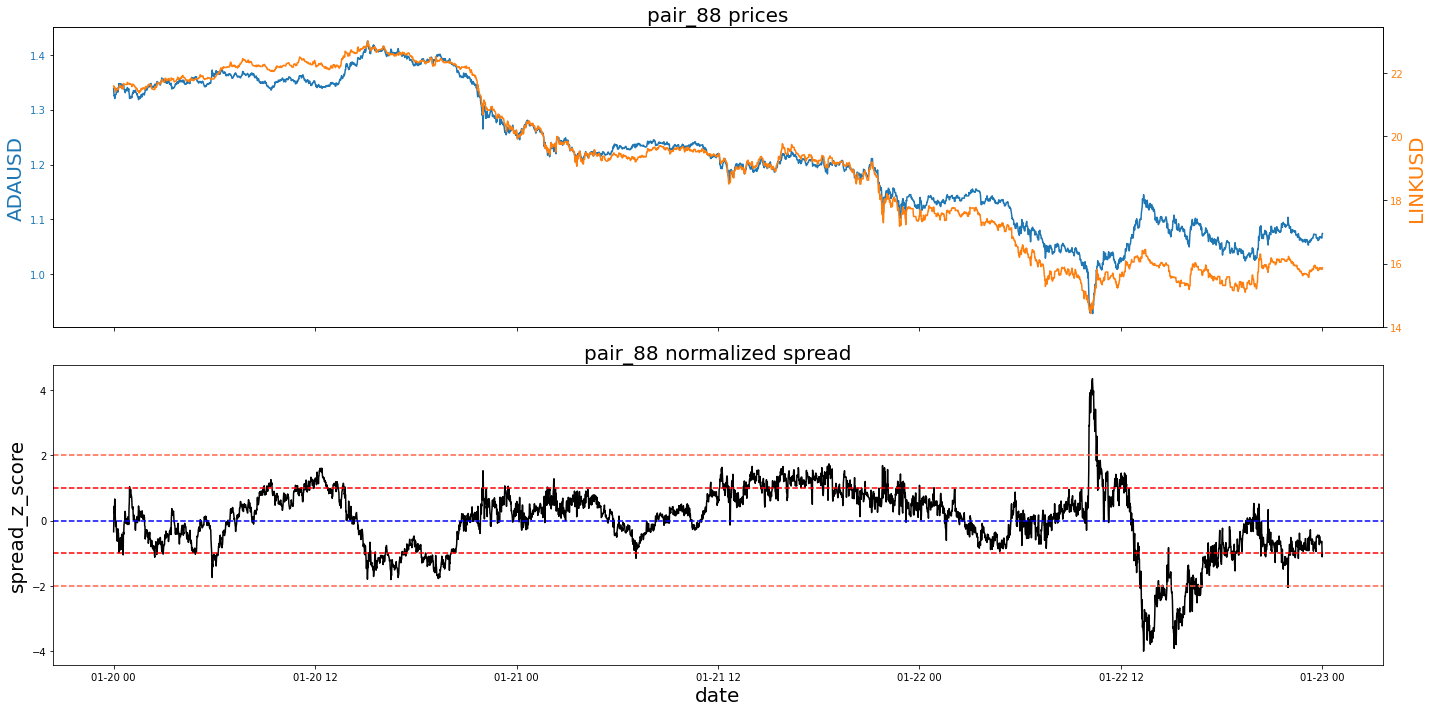

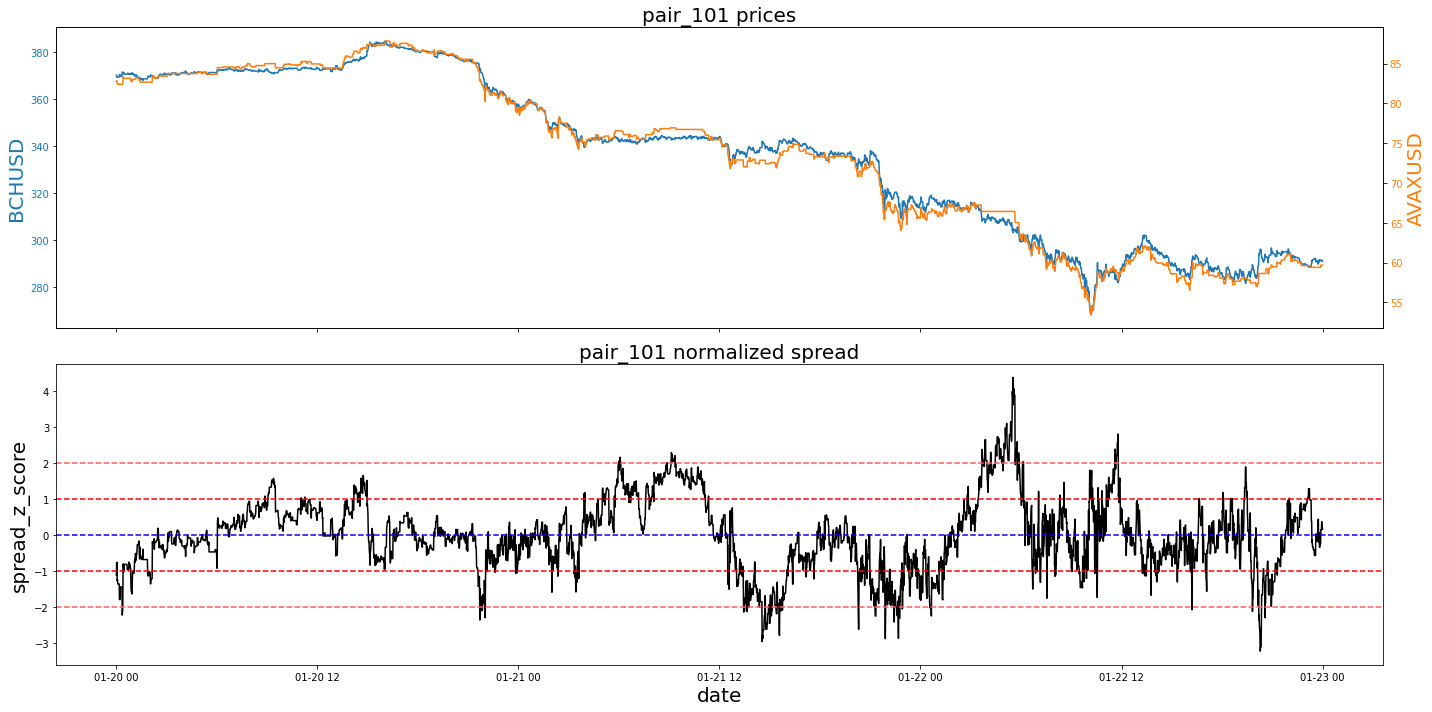

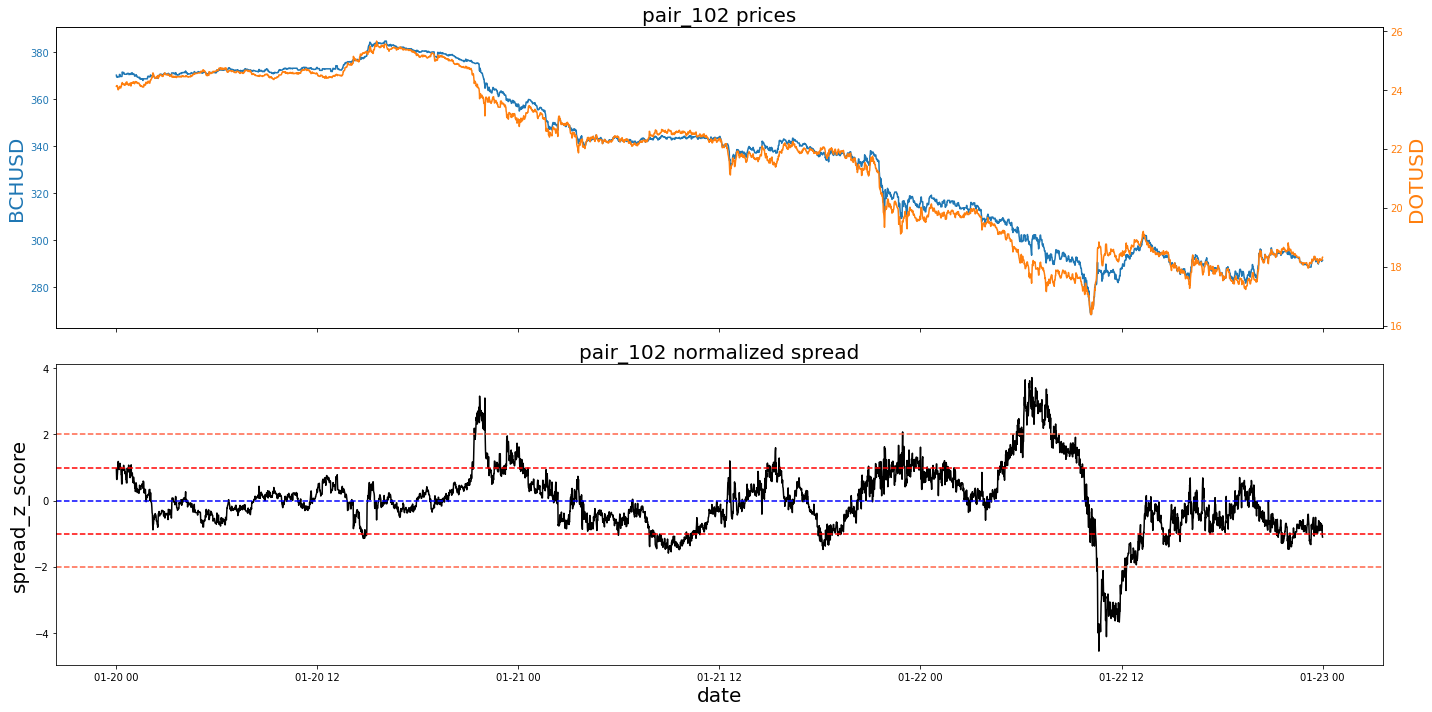

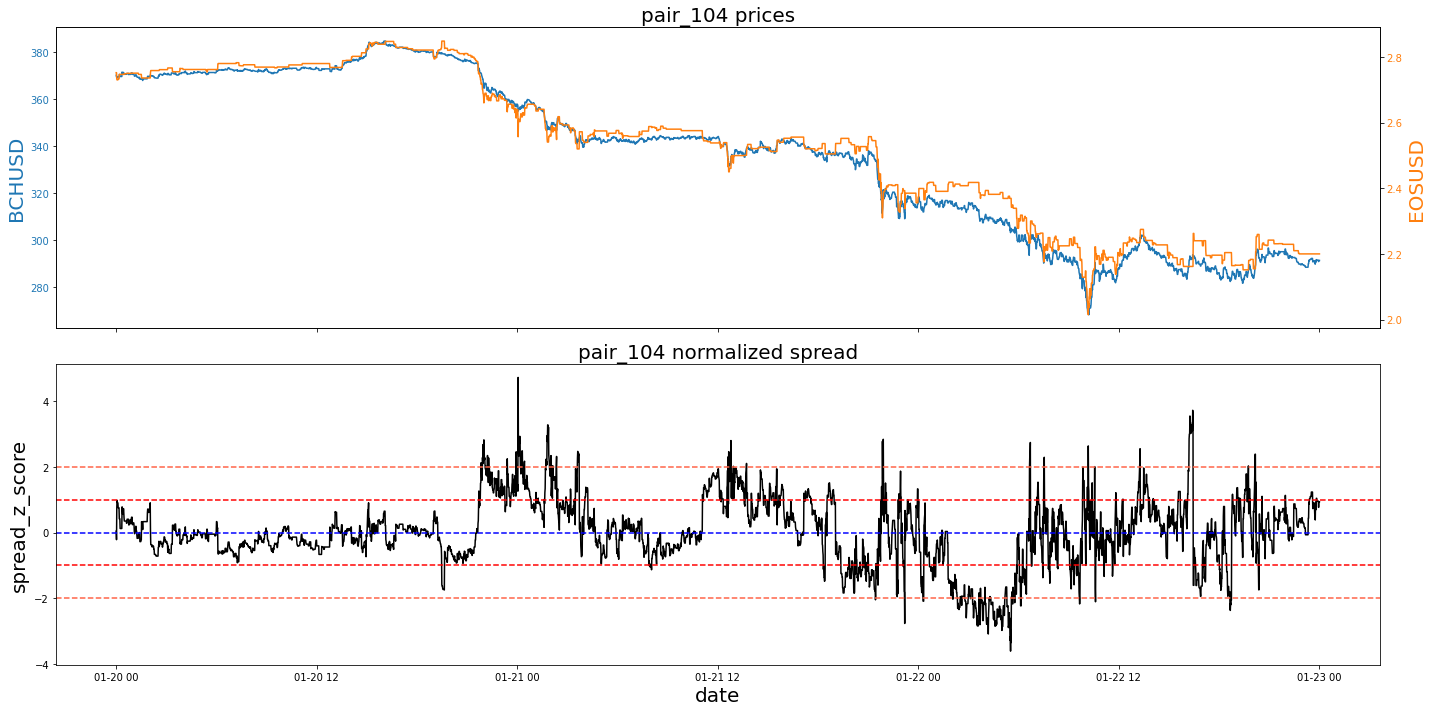

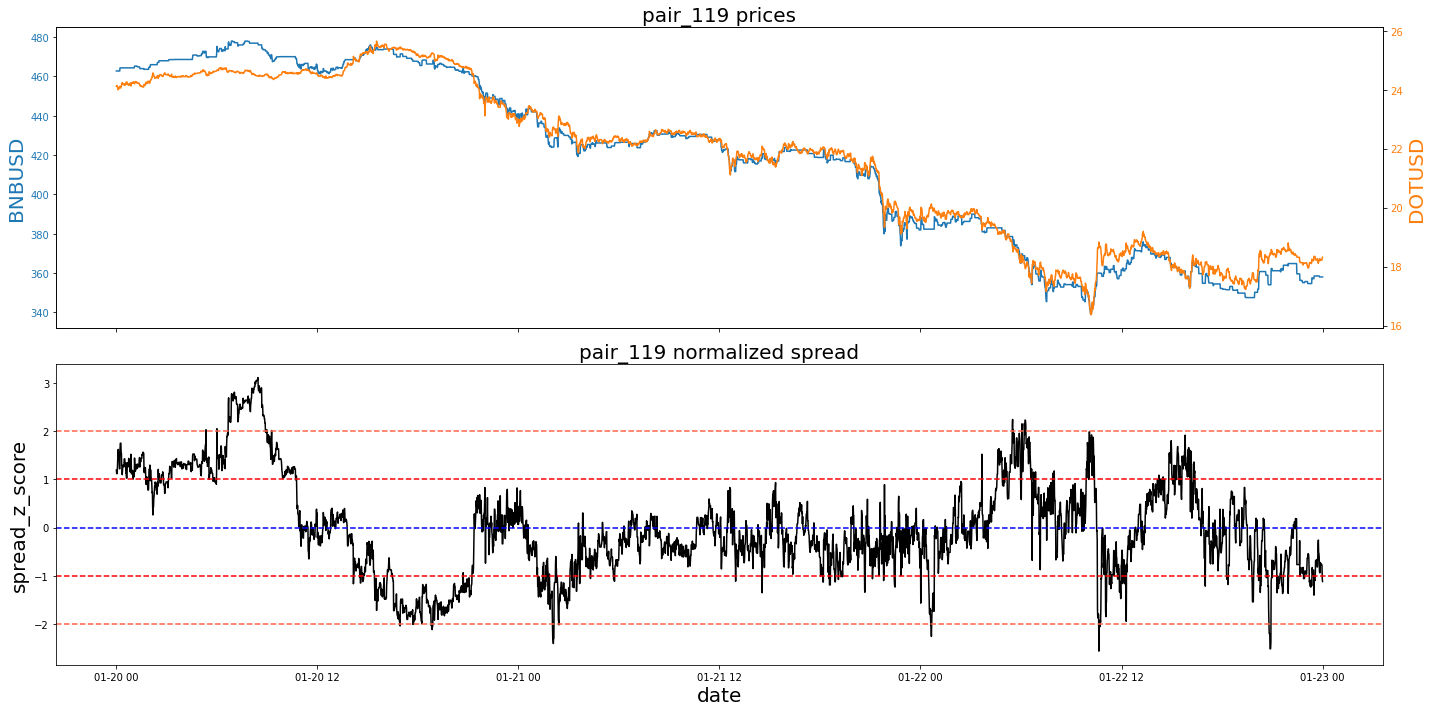

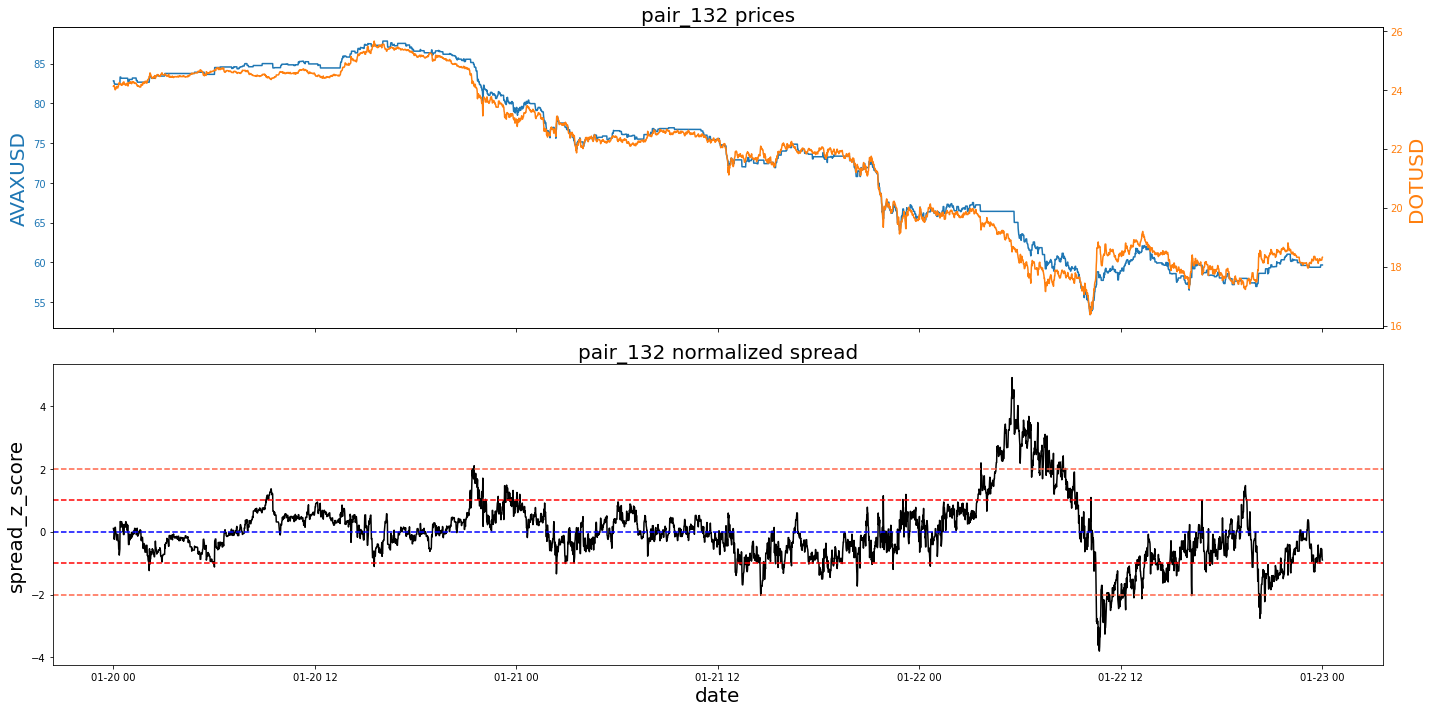

In [10]:
for i in op.filtered_pairs.index:
    op.plot_pair_price_spread(idx=i)

## Conclusion


This notebook demonstrates an empirical example of the pairs selection process outlined in [1] to efficiently reduce the search space and select quality trading pairs. Roughly 9 years of daily stock price data for 600 securities were reduced to 10 dimensions through principal component analysis. Next, over 300 potential trading pairs were identified through OPTICS clustering. Seven pairs from the clusters met the four selection criteria.

### Works Cited:
[1] Sarmento, Simão, and Nuno Horta. “A Machine Learning Based Pairs Trading Investment Strategy: Simão Sarmento.” Springer, Springer International Publishing, 2020, www.springer.com/gp/book/9783030472504.  

[2] M. Ankerst, M. M. Breunig, H.-P. Kriegel, and J. Sander, “Optics: ordering points to identify the clustering structure,” in ACM Sigmod record, vol. 28, no. 2. ACM, 1999, pp. 49–60.
